<a href="https://colab.research.google.com/github/gregmaya/geo_test/blob/main/NEWS_bearing_with_Voronoi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
!pip install pandas fiona shapely pyproj pygeos

In [ ]:
%pip install geopandas 

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from shapely.ops import voronoi_diagram

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#Function

In [2]:
def news_bearings_country(country_name, geometry):
  """
  This function creates a 5 part split for countries polygons using a combined\ 
  approach between bounding boxes and voroni diagram.

  The idea is to establish which areas could be considered N/S/E/W and Center\
  from a geography from which one is not too familiar.

  PARAMETERS
  -----
  country_name : string.
  geometry : type shapely Polygon. 

  RETURN
  -----
  Returns a GeoDataFrame indexed with the respective bearing for each area.
  """ 
  #creating a bounding box
  bounds = geometry.bounds
  ls_pts = [Point(bounds[0], bounds[3]),
            Point(bounds[2], bounds[3]),
            Point(bounds[2], bounds[1]),
            Point(bounds[0], bounds[1])]
  bbox = Polygon(ls_pts)

  #creating an ortogonal cross within it
  midx = bounds[0]+((bounds[2]-bounds[0])/2)
  midy = bounds[1]+((bounds[3]- bounds[1])/2)
  vline = LineString([Point(midx, bounds[3]), Point(midx, bounds[1])])
  hline = LineString([Point(bounds[0], midy), Point(bounds[2], midy)])
  cross = MultiLineString([vline,hline])

  #intersecting such cross with the country's geometry to get points
  vpoints = geometry.exterior.intersection(cross)
  vpoints_ls = [pt for pt in vpoints.geoms]

  #Selecting only the outter most points: N,E,W,S
  t_minx, t_miny, t_maxx, t_maxy = MultiPoint(points=list(vpoints_ls)).bounds
  bearing = []
  outer_pts = []
  for p in vpoints_ls:
    #points on verticval line
    if p.x == midx:
      if p.y == t_maxy :
        bearing.append('N')
        outer_pts.append(p)
      elif p.y == t_miny:
        bearing.append('S')
        outer_pts.append(p)
    #points on horizontal line
    elif p.y == midy:
      if p.x == t_maxx :
        bearing.append('E')
        outer_pts.append(p)
      elif p.x == t_minx:
        bearing.append('W')
        outer_pts.append(p)
        
  #Add the geometry's centroid to the origin points
  outer_pts.append(geometry.centroid)
  bearing.append('C') #this could be avoided

  origin_pts = gpd.GeoDataFrame({'bearing': bearing}, 
                                geometry = outer_pts)

  origins = MultiPoint(points=list(outer_pts))
  #create Voronoi diagram
  voro = voronoi_diagram(origins, envelope=bbox, edges=False)
  voro = MultiPolygon([poly for poly in voro.geoms])

  #Intersect with the country's geometry to get N,E,W,S & Central areas
  new_areas = []
  for p in voro.geoms:
    na = p.intersection(geometry)
    new_areas.append(na)
  
  # Determing which bearing the polygon belongs to
  news_gdf = gpd.GeoDataFrame(geometry = new_areas)
  #adding a spatial index to be able to do spatial joins
  news_gdf.sindex
  origin_pts.sindex

  voro_gdf = gpd.sjoin_nearest(news_gdf,origin_pts).drop(columns = 'index_right')
  voro_gdf['country'] = country_name
  voro_gdf.set_index('bearing', inplace=True)
  return voro_gdf

# Load data

In [ ]:
#load the files
filepath = '/content/drive/MyDrive/Playing with data/World_Countries_(Generalized)/World_Countries__Generalized_.shp'
world = gpd.read_file(filepath)
raw_filepath = '/content/drive/MyDrive/Playing with data/country-and-continent-codes-list-csv.csv'
raw = pd.read_csv(raw_filepath)

#join them
joined = pd.merge(world, raw, left_on= 'AFF_ISO', right_on='Two_Letter_Country_Code',
         how="left", sort=False)
joined.head()

,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,1,American Samoa,AS,United States,US,0.600124,0.013720,"POLYGON ((-170.74390 -14.37555, -170.74942 -14...",North America,NaN,United States of America,US,USA,840.0
1,2,United States Minor Outlying Islands,UM,United States,US,0.480216,0.003216,"MULTIPOLYGON (((-160.02114 -0.39805, -160.0281...",North America,NaN,United States of America,US,USA,840.0
2,3,Cook Islands,CK,New Zealand,NZ,0.980664,0.013073,"MULTIPOLYGON (((-159.74698 -21.25667, -159.793...",Oceania,OC,New Zealand,NZ,NZL,554.0
3,4,French Polynesia,PF,France,FR,3.930211,0.175332,"MULTIPOLYGON (((-149.17920 -17.87084, -149.258...",Europe,EU,"France, French Republic",FR,FRA,250.0
4,5,Niue,NU,New Zealand,NZ,0.541413,0.021414,"POLYGON ((-169.89389 -19.14556, -169.93088 -19...",Oceania,OC,New Zealand,NZ,NZL,554.0


In [ ]:
keep_cols = ['Continent_Name','Country_Name', 'geometry']
selection = input('Enter continent name: ')
df = joined[joined.Continent_Name == selection][keep_cols].reset_index(drop=True)

Enter continent name South America


In [ ]:
results = []
#iterate through every country
for i, mp  in df.iterrows() :
  #iterate through every polygon of such country
  c = df['Country_Name'][i]
  if mp['geometry'].geom_type == 'Polygon':
    r = news_bearings_country(c, mp['geometry'])
    results.append(r)
  elif mp['geometry'].geom_type == 'MultiPolygon':
    for g in mp['geometry'].geoms :
      r = news_bearings_country(c, g)
      results.append(r)
result = pd.concat(results)
result.tail()

#Visualising

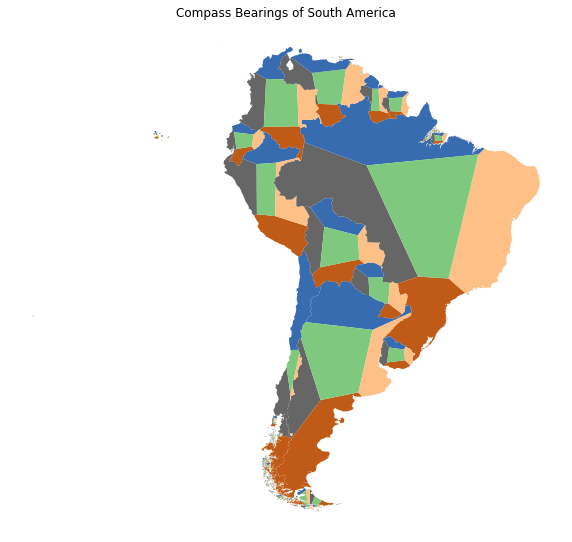

In [ ]:
# Plot data
fig, ax = plt.subplots(figsize=(10, 10))

result.reset_index().plot(ax =ax , column = 'bearing',  cmap = 'Accent')

ax.set(title='Compass Bearings of '+ 'South America' )

ax.set_axis_off()
plt.show()